# **Machine Learning from Data**

## Lab 8: Decision Trees and Random Forest

2021 - Veronica Vilaplana - [GPI @ IDEAI](https://imatge.upc.edu/web/) Research group

-----------------

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.tree
import sklearn.ensemble
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV

#Decision Trees
Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation

`DecisionTreeClassifier` is a class capable of performing multi-class classification on a dataset.

As with other classifiers, DecisionTreeClassifier takes as input two arrays: an array X, sparse or dense, of shape `(n_samples, n_features)` holding the training samples, and an array Y of integer values, shape `(n_samples,)`, holding the class labels for the training samples

Scikit-Learn uses the CART algorithm, which produces only binary trees: nonleaf nodes always have two children (i.e., questions only have yes/no answers). CART constructs binary trees using the feature and threshold that yield the largest information gain at each node. scikit-learn uses an optimised version of the CART algorithm; however, scikit-learn implementation does not support categorical variables for now.

The main parameters are:
* **criterion:** The function to measure the quality of a split. Supported criteria are “gini” (default) for the Gini impurity and “entropy” for the information gain.
* **max_depth:** The maximum depth of the tree. If None (default), then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
* **min_samples_split:** The minimum number of samples required to split an internal node (default=2)
* **min_samples_leaf** The minimum number of samples required to be at a leaf node (default 1). A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
* **class_weight** Weights associated with classes (default None).

## Part1: Toy example
Before working on our real dataset, we will "play" with a synthetic dataset in 2D to learn how to visualize a tree and to see the effect of some parameters on the decision boundaries.

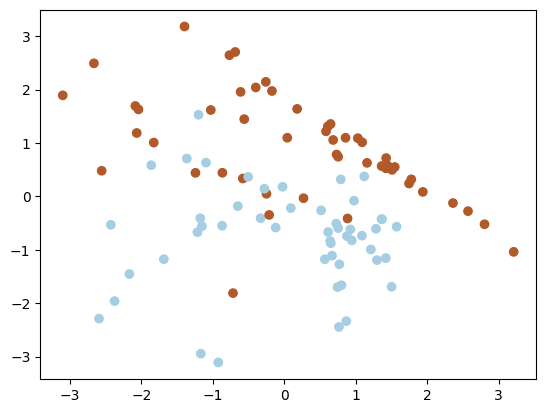

In [2]:
from sklearn.datasets import make_classification
X, y = make_classification(n_features=2, n_informative=2, n_redundant=0, random_state=3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired);

In [3]:
# Here we use the information gain criterion:
clf = sklearn.tree.DecisionTreeClassifier(criterion='entropy'  )
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy')

Which are the default values of the tree depth controllers for growing the tree? (`max_depth`, `min_samples_split`, `min_samples_leaf`, `max_leaf_nodes` and `min_impurity_split`)

We can check the parameters used by the estimator with `get_params`

In [4]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

We can visualize the tree graph using the `sklearn.tree.plot_tree` function.
On each tree node the total number of samples ("samples") and the number of samples per class ("value") are displayed, along with the entropy and the split criteria for non-leaf nodes ("X[\<FEAT_NUM\>] <= x").

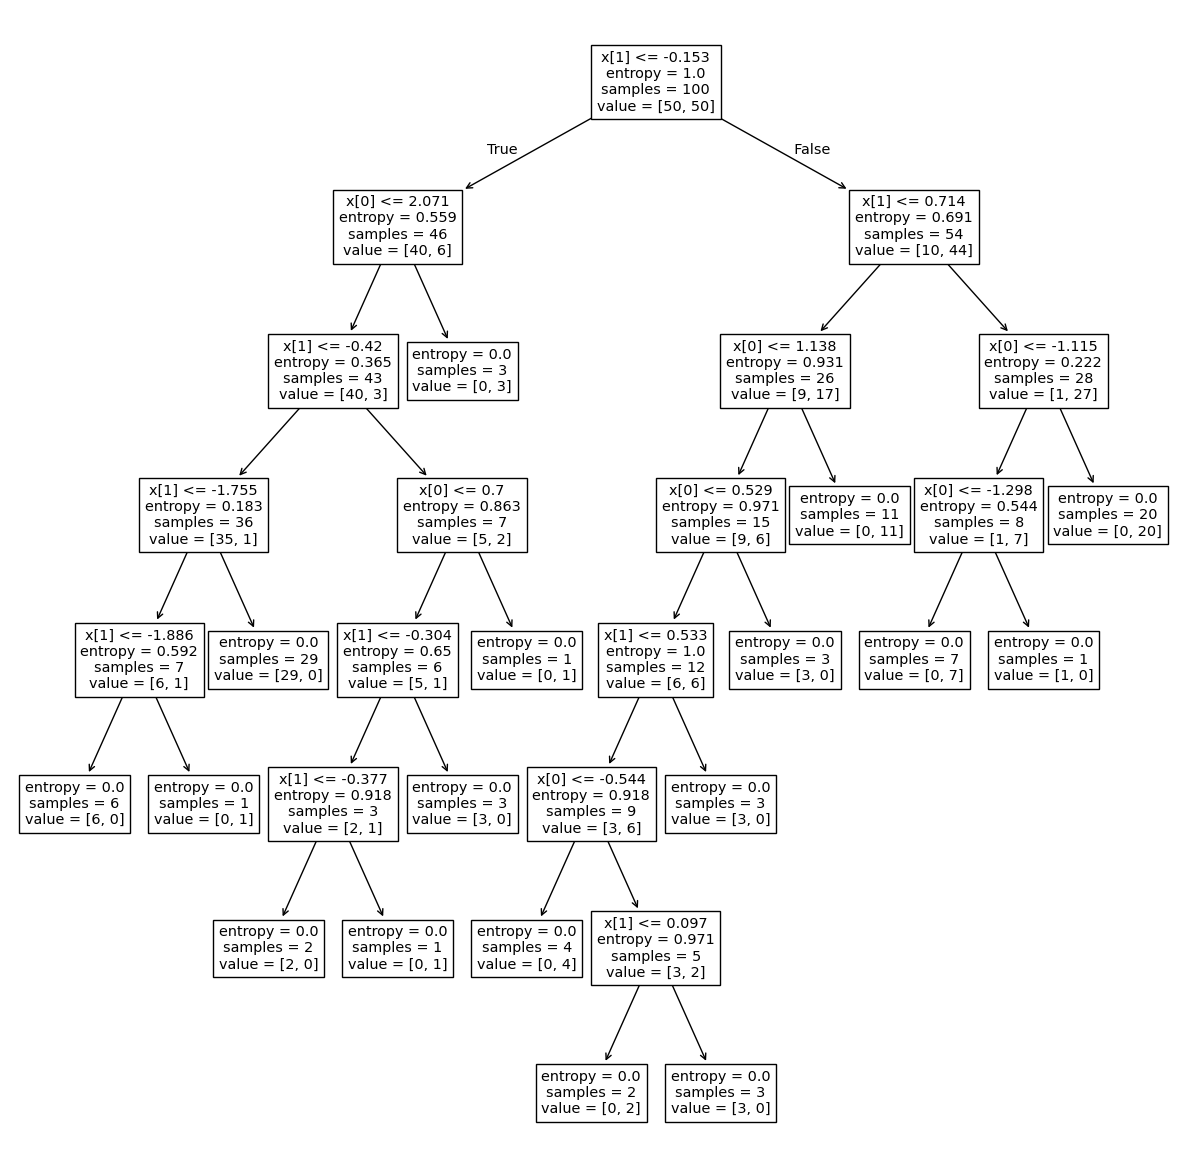

In [5]:
fig = plt.figure(figsize=(15, 15))
sklearn.tree.plot_tree(clf, ax=fig.subplots());

Also, the importance the features can be computed with the `feature_importances_` property. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.



In [6]:
clf.feature_importances_

array([0.33970412, 0.66029588])

In [7]:
def plot_decision_regions(clf, X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10,
                cmap=plt.cm.Paired, edgecolors='k')

    x_min = -3.5
    x_max = 3.5
    y_min = -3.5
    y_max = 3.5

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape(XX.shape)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.contour(XX, YY, Z, colors=['k'], linestyles=['-'], levels=[0])

    # Put the result into a color plot
    plt.pcolormesh(XX, YY, Z, cmap=plt.cm.Paired)

    # Error as title.
    error = 1. - accuracy_score(y, clf.predict(X))
    plt.title("Error=%.2f" % error)

As it can be seen in the following plot, the decision tree learned with the default parameters is too complex.

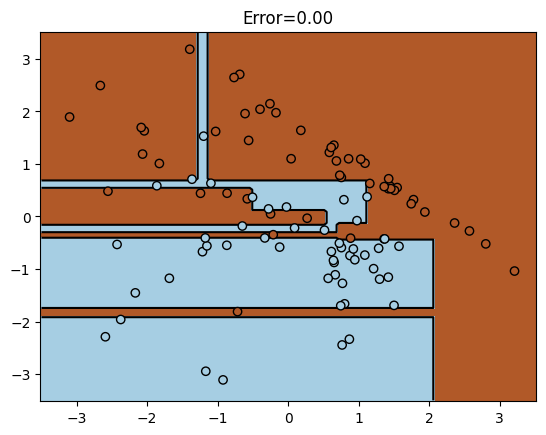

In [8]:
plot_decision_regions(clf, X, y)

#Regularization
Decision Trees make very few assumptions about the training data. If left unconstrained, the tree structure will adapt itself to the training data, fitting it very closely, most likely overfitting it. To avoid overfitting the training data, we need to restrict the Decision Tree’s freedom during training.

In Scikit-Learn, this is controlled by the following parameters:
* `max_depth` (default= None)
* `min_samples_split` (the minimum number of samples a node
must have before it can be split)
* `min_samples_leaf` (the minimum number of samples a
leaf node must have)
* `min_weight_fraction_leaf` (same as min_samples_leaf but
expressed as a fraction of the total number of weighted instances),
* `max_leaf_nodes` (the maximum number of leaf nodes)
* `max_features` (the maximum number of features that are evaluated for splitting at each node).

We can control the maximum depth of the tree with the parameter `max_depth`. We will train a decision tree with a `max_depth` of 2, and see the resulting tree and decision boundary.

In [9]:
clf = sklearn.tree.DecisionTreeClassifier(criterion='entropy', max_depth=2)
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

In [10]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

We visualize the tree with the plot_tree function:

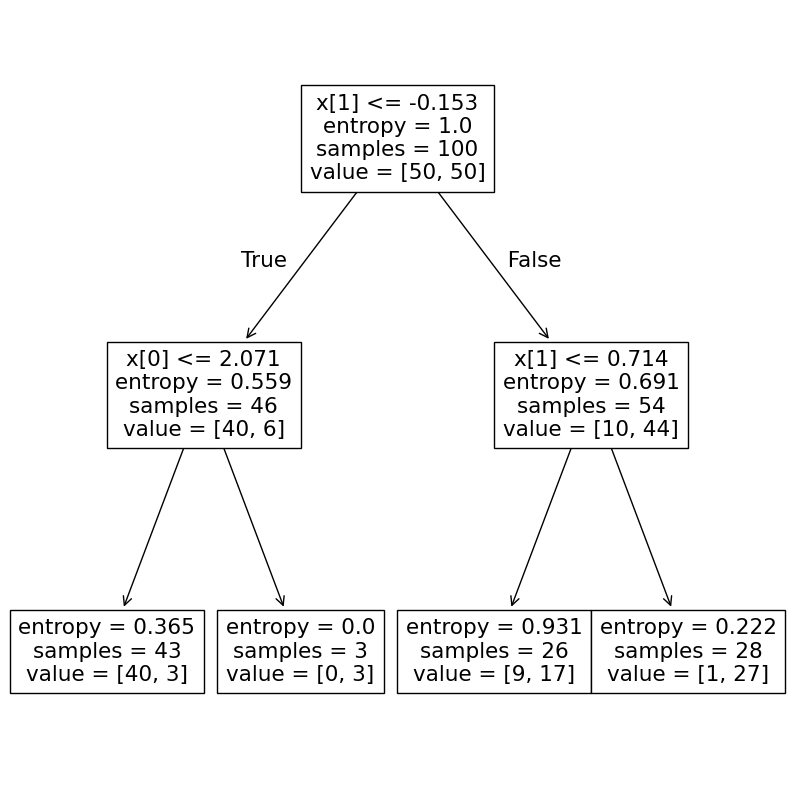

In [11]:
fig = plt.figure(figsize=(10, 10))
sklearn.tree.plot_tree(clf, ax=fig.subplots());

For visualization we can also export the tree in Graphviz format using the export_graphviz exporter.

The export_graphviz exporter also supports a variety of aesthetic options, including coloring nodes by their class (or value for regression) and using explicit variable and class names if desired.

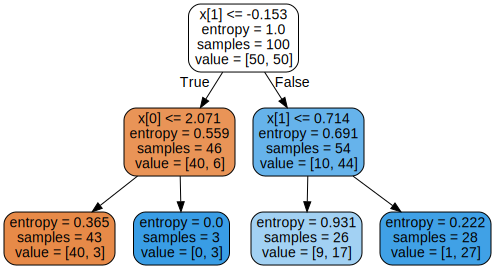

In [12]:
from graphviz import Source
from sklearn.tree import export_graphviz

dot_data = export_graphviz(clf, out_file=None,rounded=True, filled=True )
graph = Source(dot_data)
graph

Alternatively, the tree can also be exported in textual format with the function `export_text`. This method doesn’t require the installation of external libraries and is more compact

In [13]:
from sklearn.tree import export_text

t = export_text(clf)
print(t)

|--- feature_1 <= -0.15
|   |--- feature_0 <= 2.07
|   |   |--- class: 0
|   |--- feature_0 >  2.07
|   |   |--- class: 1
|--- feature_1 >  -0.15
|   |--- feature_1 <= 0.71
|   |   |--- class: 1
|   |--- feature_1 >  0.71
|   |   |--- class: 1



Now we plot the decision regions for the regularized model and see the feature importances:

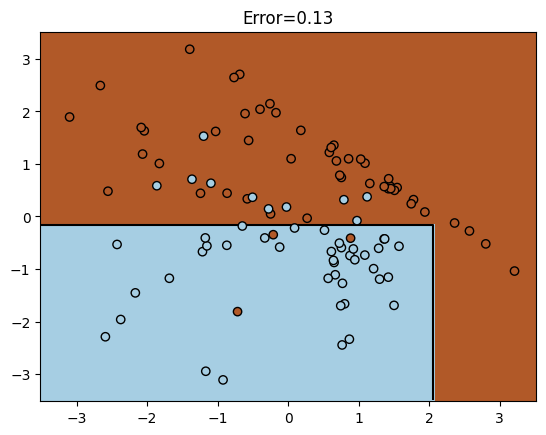

In [14]:
plot_decision_regions(clf, X, y)

In [15]:
clf.feature_importances_

array([0.18557804, 0.81442196])

## Random forest with the toy example

### Random Forests
To improve the predictive accuracy and control over-fitting, multiple decision tree classifiers can be trained and later combined. In random forests, randomness is introduced in the classifier construction by two means:
1. Each tree is built from a sample drawn with replacement from the training set.
2. When splitting each node during the construction of a tree, the best split is found from a random subset from the input features.

Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice the variance reduction is often significant hence yielding an overall better model.

The Scikit-learn class is `RandomForestClassifier`

In [16]:
# Use information gain criterion
clf = sklearn.ensemble.RandomForestClassifier(criterion='entropy',min_samples_leaf=5)
clf.fit(X, y)

RandomForestClassifier(criterion='entropy', min_samples_leaf=5)

In [17]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

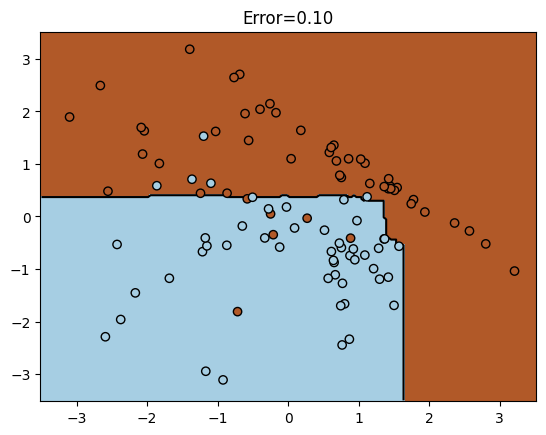

In [18]:
plot_decision_regions(clf, X, y)

# Part2: The Ionosphere classification problem

## Data loading

Data available in [UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/ionosphere).

It contains 351 observations of 34 different variables collected form an array of 16 high-frequency antennas.

It is a binary classification task, "good" radar returns are those showing evidence of some type of structure in the ionosphere.  "Bad" returns are those that do not; their signals pass through the ionosphere.

In [19]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data",
                   header=None)

In [20]:
X = data.iloc[:, :-1].to_numpy()
y = data.iloc[:, -1].to_numpy()

We split the data into training and test subsets (80% and 20%)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

###Training a Decision Tree
We use first the default parameters

In [22]:
clf = sklearn.tree.DecisionTreeClassifier(random_state=1)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [23]:
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

In [24]:
print("TRAINING\n" + classification_report(y_train, pred_train))
print("\nTESTING\n" + classification_report(y_test, pred_test))

TRAINING
              precision    recall  f1-score   support

           b       1.00      1.00      1.00        98
           g       1.00      1.00      1.00       182

    accuracy                           1.00       280
   macro avg       1.00      1.00      1.00       280
weighted avg       1.00      1.00      1.00       280


TESTING
              precision    recall  f1-score   support

           b       0.73      0.79      0.76        28
           g       0.85      0.81      0.83        43

    accuracy                           0.80        71
   macro avg       0.79      0.80      0.80        71
weighted avg       0.81      0.80      0.80        71



In [25]:
train_error = 1. - accuracy_score(y_train, pred_train)
train_cmat = confusion_matrix(y_train, pred_train)
test_error = 1. - accuracy_score(y_test, pred_test)
test_cmat = confusion_matrix(y_test, pred_test)

print('train error: %f ' % train_error)
print('train confusion matrix:')
print(train_cmat)
print('test error: %f ' % test_error)
print('test confusion matrix:')
print(test_cmat)

train error: 0.000000 
train confusion matrix:
[[ 98   0]
 [  0 182]]
test error: 0.197183 
test confusion matrix:
[[22  6]
 [ 8 35]]


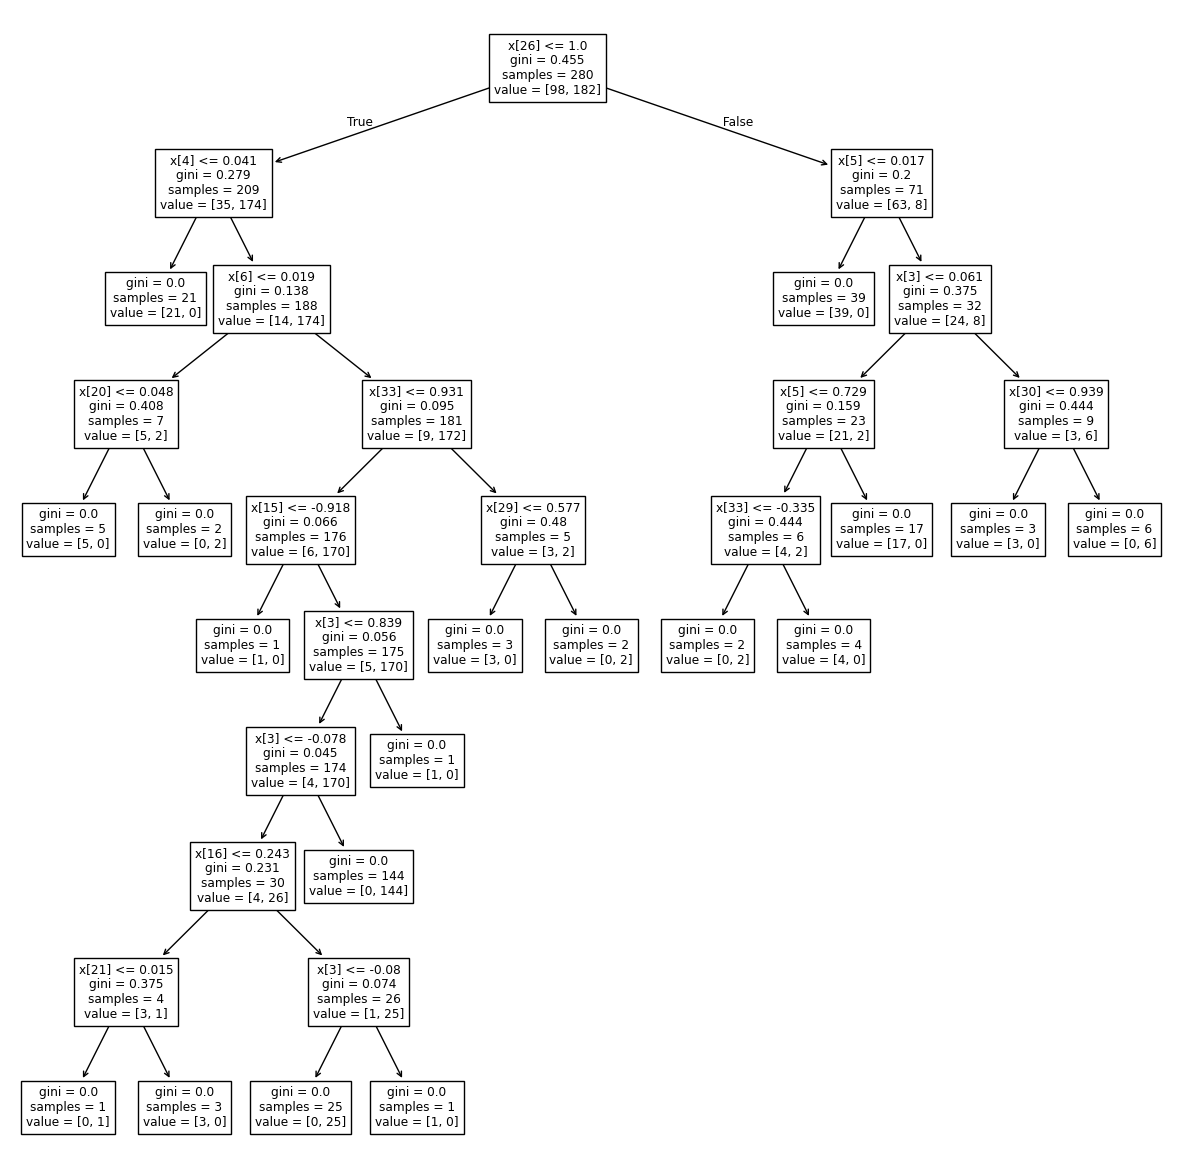

In [26]:
fig = plt.figure(figsize=(15, 15))
sklearn.tree.plot_tree(clf, ax=fig.subplots());

The importance the features can be computed with the `feature_importances_` property.

The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance. Warning: impurity-based feature importances can be misleading for high cardinality features (many unique values). See [sklearn.inspection.permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance) as an alternative.

In [27]:
clf.feature_importances_

array([0.        , 0.        , 0.        , 0.07105067, 0.25402369,
       0.02498187, 0.04672511, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01473017, 0.02755303, 0.        , 0.        , 0.        ,
       0.02242655, 0.01177394, 0.        , 0.        , 0.        ,
       0.        , 0.43112484, 0.        , 0.        , 0.0188383 ,
       0.03139717, 0.        , 0.        , 0.04537465])

### Hyperparameter search:
Now you will select the value of `max_leaf_nodes` and `min_samples_split` by crossvalidation.


###Add the code to
1. Use grid search with cross-validation (with the help of the GridSearchCV class) to find good hyperparameter values for a DecisionTreeClassifier. Parameter values: {'max_leaf_nodes': list(range(2, 100, 10)), 'min_samples_split': [2, 3, 4]}
2. Make predictions on the train and test sets using the best value of the hyperparameter
3. Print the classification report for the train and the test sets (for the best hyperparameter)
4. Print the error and confusion matrices for the train and test sets (for the best hyperparameters)
5. Show the grid_search.cv_results as a pandas DataFrame

In [28]:
## your code here
param_grid = {
    'max_leaf_nodes': list(range(2, 100, 10)),
    'min_samples_split': [2, 3, 4]
}

clf = sklearn.tree.DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print("\nClassification Report (Train):")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

print("\nConfusion Matrix (Train):")
print(confusion_matrix(y_train, y_train_pred))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

print("\nError (Train):", 1 - accuracy_score(y_train, y_train_pred))
print("Error (Test):", 1 - accuracy_score(y_test, y_test_pred))

cv_results_df = pd.DataFrame(grid_search.cv_results_)
print("\nGrid Search Results:")
print(cv_results_df)

Best Parameters: {'max_leaf_nodes': 12, 'min_samples_split': 2}

Classification Report (Train):
              precision    recall  f1-score   support

           b       0.98      0.96      0.97        98
           g       0.98      0.99      0.98       182

    accuracy                           0.98       280
   macro avg       0.98      0.97      0.98       280
weighted avg       0.98      0.98      0.98       280


Classification Report (Test):
              precision    recall  f1-score   support

           b       0.73      0.79      0.76        28
           g       0.85      0.81      0.83        43

    accuracy                           0.80        71
   macro avg       0.79      0.80      0.80        71
weighted avg       0.81      0.80      0.80        71


Confusion Matrix (Train):
[[ 94   4]
 [  2 180]]

Confusion Matrix (Test):
[[22  6]
 [ 8 35]]

Error (Train): 0.021428571428571463
Error (Test): 0.19718309859154926

Grid Search Results:
    mean_fit_time  std_fit_time

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


##Tree pruning

The DecisionTreeClassifier provides parameters such as `min_samples_leaf` and `max_depth` to prevent a tree from overfiting. Cost complexity pruning provides another option to control the size of a tree. In the DecisionTreeClassifier, this pruning technique is parameterized by the cost complexity parameter, `ccp_alpha`. Greater values of `ccp_alpha` increase the number of nodes pruned.

**Minimal cost-complexity pruning** is an algorithm used to prune a tree to avoid over-fitting, described in Chapter 3 of [BRE]. This algorithm is parameterized by $\alpha >= 0$, known as the complexity parameter.

The complexity parameter is used to define the cost-complexity measure of a tree $T$,

$$R_{\alpha}(T) = R(T) + \alpha |\tilde{T}|$$

where $|\tilde{T}|$ is the number of terminal nodes in $T$ and $R(T)$ is traditionally defined as the total misclassification rate of the terminal nodes. Alternatively, scikit-learn uses the total sample weighted impurity of the terminal nodes for $R(T)$.

The impurity of a node depends on the criterion. Minimal cost-complexity pruning finds the subtree of $T$ that minimizes $R_{\alpha}(T)$.

You can read more details here: https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning

BRE L. Breiman, J. Friedman, R. Olshen, and C. Stone. Classification and Regression Trees. Wadsworth, Belmont, CA, 1984.




Now we will  prune the tree using this method. You will have to select the best value of `ccp_alpha` by crossvalidation.

###Add the code to
1. perform a GridSearchCV
2. make predictions on the train and test sets using the best value of the hyperparameter
3. print the classification report for the train and the test sets (for the best hyperparameter)
4. print the error and confusion matrices for the train and test sets (for the best hyperparameters)
5. show in the same figure two plots with the mean train and mean test scores for each value of the hyperparameter

In [29]:
alphas = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

Best Parameters: {'ccp_alpha': 0}

Classification Report (Train):
              precision    recall  f1-score   support

           b       1.00      1.00      1.00        98
           g       1.00      1.00      1.00       182

    accuracy                           1.00       280
   macro avg       1.00      1.00      1.00       280
weighted avg       1.00      1.00      1.00       280


Classification Report (Test):
              precision    recall  f1-score   support

           b       0.73      0.79      0.76        28
           g       0.85      0.81      0.83        43

    accuracy                           0.80        71
   macro avg       0.79      0.80      0.80        71
weighted avg       0.81      0.80      0.80        71


Confusion Matrix (Train):
[[ 98   0]
 [  0 182]]

Confusion Matrix (Test):
[[22  6]
 [ 8 35]]

Error (Train): 0.0
Error (Test): 0.19718309859154926


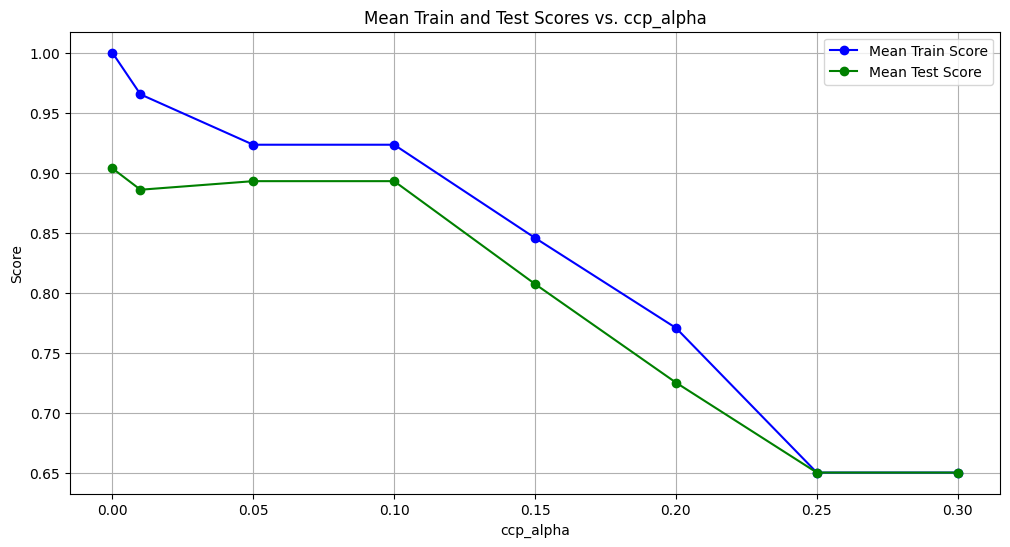

In [30]:
param_grid = {'ccp_alpha': alphas}

clf = sklearn.tree.DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)


print("\nClassification Report (Train):")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))


print("\nConfusion Matrix (Train):")
print(confusion_matrix(y_train, y_train_pred))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

print("\nError (Train):", 1 - accuracy_score(y_train, y_train_pred))
print("Error (Test):", 1 - accuracy_score(y_test, y_test_pred))


cv_results_df = pd.DataFrame(grid_search.cv_results_)


alphas = param_grid['ccp_alpha']
mean_train_scores = grid_search.cv_results_['mean_train_score']
mean_test_scores = grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(12, 6))


plt.plot(alphas, mean_train_scores, label="Mean Train Score", marker='o', color='blue')

plt.plot(alphas, mean_test_scores, label="Mean Test Score", marker='o', color='green')

plt.title("Mean Train and Test Scores vs. ccp_alpha")
plt.xlabel("ccp_alpha")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

### Random forest
Finally we will train a Random Forest to solve the Ionosphere classification problem.

In random forests, each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set.

Furthermore, when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of size ´max_features´. (See the [parameter tuning guidelines](https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters) for more details).

The purpose of these two sources of randomness is to decrease the variance of the forest estimator. Individual decision trees typically have high variance and tend to overfit. The randomness introduced in forests produces decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias.
Usually the reduction in variance is significant, yielding an overall better model.

The scikit-learn implementation of random forests combines classifiers by averaging their probabilistic prediction, instead of letting each classifier vote for a single class.

In [31]:
clf = sklearn.ensemble.RandomForestClassifier(criterion='entropy',min_samples_leaf=5, random_state=1)
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=5, random_state=1)

In [32]:
clf.score(X_test, y_test)

0.9014084507042254

In [33]:
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

In [34]:
train_error = 1. - accuracy_score(y_train, pred_train)
train_cmat = confusion_matrix(y_train, pred_train)
test_error = 1. - accuracy_score(y_test, pred_test)
test_cmat = confusion_matrix(y_test, pred_test)

print('train error: %f ' % train_error)
print('train confusion matrix:')
print(train_cmat)
print('test error: %f ' % test_error)
print('test confusion matrix:')
print(test_cmat)

train error: 0.028571 
train confusion matrix:
[[ 91   7]
 [  1 181]]
test error: 0.098592 
test confusion matrix:
[[22  6]
 [ 1 42]]


In [35]:
print("TRAINING\n" + classification_report(y_train, pred_train))
print("\nTESTING\n" + classification_report(y_test, pred_test))

TRAINING
              precision    recall  f1-score   support

           b       0.99      0.93      0.96        98
           g       0.96      0.99      0.98       182

    accuracy                           0.97       280
   macro avg       0.98      0.96      0.97       280
weighted avg       0.97      0.97      0.97       280


TESTING
              precision    recall  f1-score   support

           b       0.96      0.79      0.86        28
           g       0.88      0.98      0.92        43

    accuracy                           0.90        71
   macro avg       0.92      0.88      0.89        71
weighted avg       0.91      0.90      0.90        71



Also, the importance the features can be computed (the Gini importance) with the `feature_importances_` property.



In [36]:
clf.feature_importances_

array([0.02695519, 0.        , 0.0770718 , 0.03016054, 0.15408247,
       0.03176396, 0.08295619, 0.02198569, 0.01699943, 0.01618443,
       0.00537967, 0.0275902 , 0.01215537, 0.02396685, 0.01488081,
       0.0184523 , 0.01272787, 0.03506749, 0.01008395, 0.02967175,
       0.01397684, 0.01198795, 0.00918841, 0.03358974, 0.00575936,
       0.0065197 , 0.14342256, 0.02668298, 0.01931411, 0.0049968 ,
       0.02066255, 0.01676339, 0.02481927, 0.01418038])



```
# Tiene formato de código
```

##Part 3: MNIST with a random forest  

Train a random forest on the MNIST dataset.
1. Import and load the dataset (check Lab6)
2. Select subsets of 15000 images for training and 2500 for testing
3. Train a RandomForestClassifier (select some of the hyperparameters by crossvalidation). Use the name 'rnd_clf' for the model
4. Show classification report and confusion matrices for train and test sets

Next we wil use the trained classifer to create a plot showing the importance of each feature (= pixel). Code is already given and assumes that the classifier is 'rnd_clf'

In [37]:
# import and load dataset
# your code here
from tensorflow.keras.datasets import mnist

(X_train_full, y_train_full), (X_test_full, y_test_full) = mnist.load_data()

X_train_full = X_train_full.reshape(-1, 28 * 28)
X_test_full = X_test_full.reshape(-1, 28 * 28)

X_train_full = X_train_full / 255.0
X_test_full = X_test_full / 255.0


X_train, X_test, y_train, y_test = train_test_split(
    X_train_full, y_train_full, train_size=15000, test_size=2500, stratify=y_train_full, random_state=42
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20]
}

rf_clf = sklearn.ensemble.RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
rnd_clf = grid_search.best_estimator_

print("Best Parameters:", best_params)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set size: (15000, 784)
Test set size: (2500, 784)
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 150}


In [38]:
pred_train = rnd_clf.predict(X_train)
pred_test = rnd_clf.predict(X_test)

train_error = 1. - accuracy_score(y_train, pred_train)
train_cmat = confusion_matrix(y_train, pred_train)
test_error = 1. - accuracy_score(y_test, pred_test)
test_cmat = confusion_matrix(y_test, pred_test)

print('train error: %f ' % train_error)
print('train confusion matrix:')
print(train_cmat)
print('test error: %f ' % test_error)
print('test confusion matrix:')
print(test_cmat)

print("TRAINING\n" + classification_report(y_train, pred_train))
print("\nTESTING\n" + classification_report(y_test, pred_test))

train error: 0.000133 
train confusion matrix:
[[1481    0    0    0    0    0    0    0    0    0]
 [   0 1685    0    0    0    0    0    0    0    0]
 [   0    0 1490    0    0    0    0    0    0    0]
 [   0    0    0 1533    0    0    0    0    0    0]
 [   0    0    0    0 1459    0    0    0    0    1]
 [   0    0    0    0    0 1355    0    0    0    0]
 [   0    0    0    0    0    0 1480    0    0    0]
 [   0    1    0    0    0    0    0 1565    0    0]
 [   0    0    0    0    0    0    0    0 1463    0]
 [   0    0    0    0    0    0    0    0    0 1487]]
test error: 0.051600 
test confusion matrix:
[[241   0   1   0   0   0   1   0   4   0]
 [  0 274   5   0   0   0   0   0   1   1]
 [  3   2 233   2   1   0   2   2   3   0]
 [  0   0   3 236   0   5   1   3   5   2]
 [  4   0   1   0 231   0   1   0   1   5]
 [  1   1   0   5   1 214   2   0   1   1]
 [  0   0   0   0   2   4 240   0   1   0]
 [  0   2   8   0   3   0   0 247   0   1]
 [  1   1   2   4   1   1   2   0

Now we can plot the feature imporances with the following code:

In [39]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.hot,
               interpolation="nearest")
    plt.axis("off")

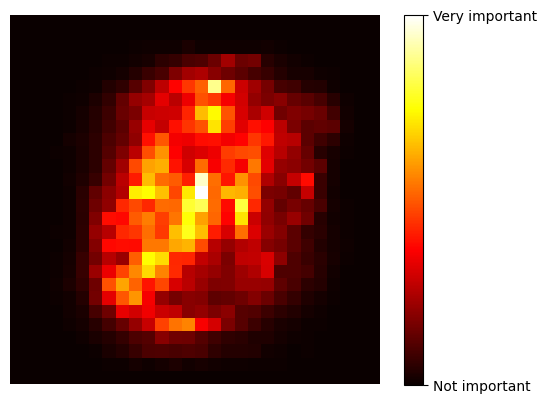

In [40]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()